# 📡 Имитационное моделирование RFID системы в зависимости от параметра `Q` и количества меток в зоне чтения

В данном блокноте проводится имитацинное моделирование RFID системы для изучения зависимости вероятности чтения банка памяти `USER` от параметра, количества меток в зоне чтения, количества коллизий. Также изучается работа команды QueryAdjust и алгоритма коррекции `Q`

### Импорт необходимых модулей

In [1]:
from pysim.experiments.utility.rfid_helper import *
from pysim.models.rfid.params import default_params

In [2]:
SAVE_FIG = False         # Сохранять ли изображения
SAVE_RESULTS = False    # Сохранять ли результаты в JSON
USE_JSON = not SAVE_RESULTS        # Использовать ли результаты из JSON

IMG_DIRECTORY = "rfid/multiple_tag/"
JSON_DIRECTORY = "../results/result_jsons/rfid/multiple_tag/"

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q`. Случай без коллизий и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разных значений `M` и `Tari`.

🎛 **Перебираемые параметры модуляции (`M`) и длительности импульса (`Tari`):**
- M = `FM0`, Tari = 6.25 мкс
- M = `FM0`, Tari = 18.75 мкс
- M = `Miller-2`, Tari = 12.5 мкс
- M = `Miller-4`, Tari = 6.25 мкс
- M = `Miller-8`, Tari = 25.0 мкс

Как хорошо видно из результатов, при небольших значениях `Q` разницы в величине вероятности почти нет. Начиная с Q = 7 вероятность чтения начинает стремительно уменьшаться из-за того, что раунд заполняется пустыми слотами и становится слишком длинным. В результате этого метка успевает принять участие в меньшем количестве раундов инвентаризации и вероятность снижается.

In [21]:
q_variable = np.arange(0, 16, 1)
coding_params = [
    {"encoding": "FM0", "tari": 6.25},
    {"encoding": "FM0", "tari": 18.75},
    {"encoding": "M2", "tari": 12.5},
    {"encoding": "M4", "tari": 6.25},
    {"encoding": "M8", "tari": 25.0},
]

q_params_list = []
for coding_params_item in coding_params:
    q_params_list.append({
        "tari": coding_params_item["tari"],
        "encoding": coding_params_item["encoding"],
        "tid_word_size": default_params.tid_word_size,
        "power": default_params.power_dbm,
        "num_tags": 1500, # default_params.num_tags,
        "speed": default_params.speed,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "altitude": 4,
        "useadjust": default_params.useadjust,
        "generation_interval": (generation_interval, 1.0)

    })

### 💾 Получение результатов

In [22]:
key_name = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [23]:
q_result = calculate_simulations(
    variable="q",
    variable_values=q_variable,
    params_list=q_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="q.json"
)
# Моделирование на M3 Pro с "num_tags": 1500:
# Моделирование по переменной q: 100%|██████████| 5/5 [19:40<00:00, 236.15s/it]

### 🖼️ Построение графика для вероятности чтения банка памяти USER

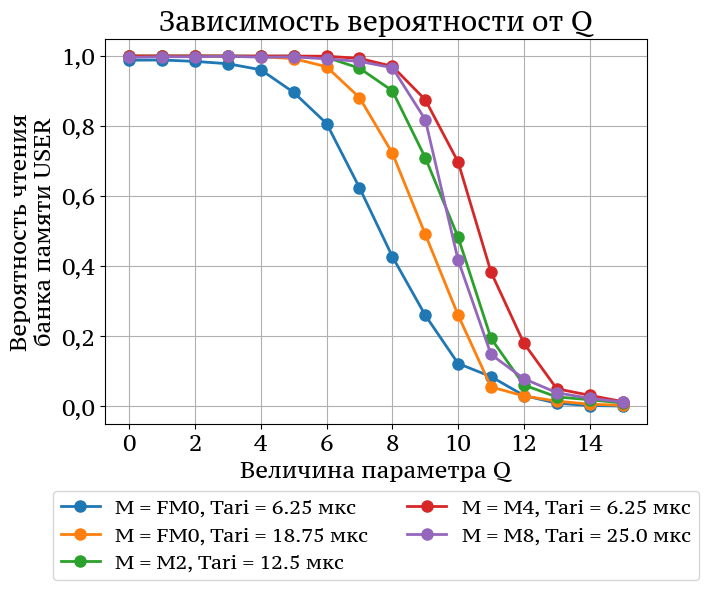

In [24]:
plot_simulations_results(
    results_list=[q_result["read_user_probs"]],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Зависимость вероятности от Q"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Q probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

### 🖼️ Построение графика для времени чтения банка памяти USER

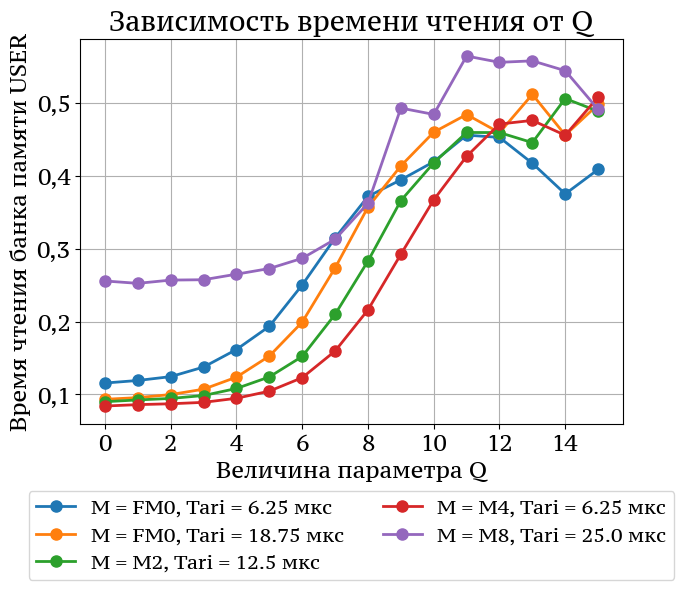

In [25]:
plot_simulations_results(
    results_list=[q_result["times_count"]],
    labels_list=[key_name(params) for params in coding_params],
    titles=["Зависимость времени чтения от Q"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    y_label="Время чтения банка памяти USER",
    image_name="Q time",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от значения параметра `Q` в случае **с коллизиями** и без использования QueryAdjust
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разного количества меток в зоне действия считывателя.



В случае появления нескольких меток в зоне чтения возникает явление коллизий. В результате чего при малых `Q` практически все метки попадают в коллизию и не могут быть считаны. Значения вероятности в таком случае примерно равны нулю. При увеличении `Q` у меток снижается вероятность попадения в коллизию, в результате чего вероятность чтения увеличивается. При этом при слишком больших значениях `Q` метки вынуждены слишком долго ждать своей очереди и вероятность чтения снова снижается.

In [3]:
TAGS_IN_READING_ZONE = (1, 5, 15, 25)

tag_intervals = [
    estimate_generation_interval(tags_amount, compute_reading_zone())
    for tags_amount in TAGS_IN_READING_ZONE
]
tag_period_params = [
    {"label": f"{n} меток", "generation_interval": (generation_interval, t)}
    for n, t in zip(TAGS_IN_READING_ZONE, tag_intervals)
]

### ⚙️ Параметры для разных кривых

In [4]:
q_variable = np.arange(2, 16, 1)
colllision_params_list = []

for tag_params_item in tag_period_params:
    colllision_params_list.append({
        "tari": default_params.tari,
        "encoding":  default_params.encoding,
        "tid_word_size": default_params.tid_word_size,
        "power": default_params.power_dbm,
        "num_tags": 1500,
        "speed": default_params.speed,
        "reader_offset": default_params.reader_offset,
        "tag_offset": default_params.tag_offset,
        "altitude": 4,
        "useadjust": False,
        "generation_interval": tag_params_item["generation_interval"],
        "tags_amount": int(tag_params_item["label"].split()[0]),
        "label": tag_params_item["label"]
    })

### 💾 Получение результатов

In [5]:
key_name = lambda params: f"{params["label"]}"

In [6]:
collision_result = calculate_simulations(
    variable="q",
    variable_values=q_variable,
    params_list=colllision_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision.json"
)
# Моделирование на M3 Pro с "num_tags": 1500:
# Моделирование по переменной q: 100%|██████████| 4/4 [10:05<00:00, 151.27s/it]

### 🖼️ Построение графика для вероятности чтения банка памяти USER

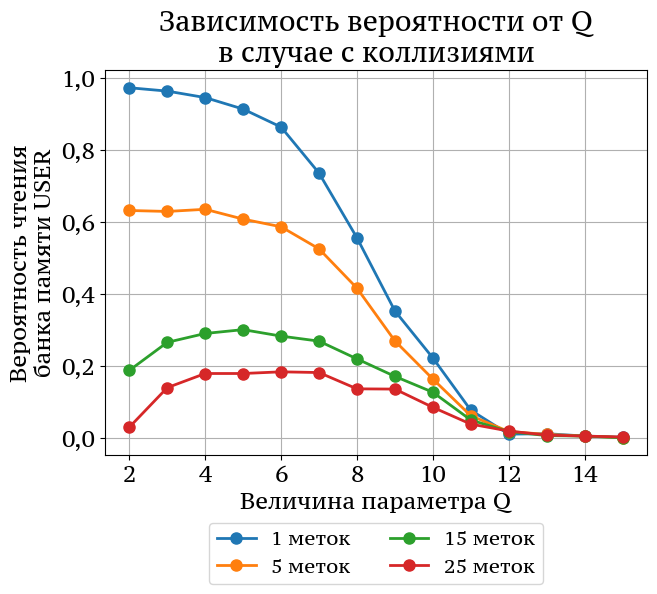

In [7]:
plot_simulations_results(
    results_list=[collision_result["read_user_probs"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от Q\nв случае с коллизиями"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    image_name="Collision probs",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

### 🖼️ Построение графика для времени чтения банка памяти USER

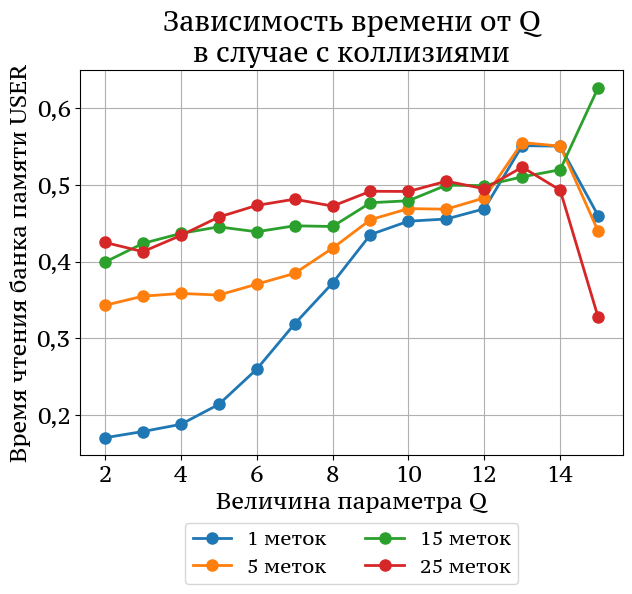

In [9]:
plot_simulations_results(
    results_list=[collision_result["times_count"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от Q\nв случае с коллизиями"],
    x_variable=q_variable,
    x_label="Величина параметра Q",
    y_label="Время чтения банка памяти USER",
    image_name="Collision times",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

## 📈 Зависимость вероятности чтения банка памяти `USER` от стартового значения параметра `Q` в случае **с коллизиями с использованием алгоритма QueryAdjust**
🔍 **Вариации параметров:**
- Изменяется переменная `Q` от **0 до 15** с шагом 1.
- Построены кривые для разного количества меток в зоне действия считывателя.



В случае появления нескольких меток в зоне чтения возникает явление коллизий. В результате чего при малых `Q` практически все метки попадают в коллизию и не могут быть считаны. Значения вероятности в таком случае примерно равны нулю. При увеличении `Q` у меток снижается вероятность попадения в коллизию, в результате чего вероятность чтения увеличивается. При этом при слишком больших значениях `Q` метки вынуждены слишком долго ждать своей очереди и вероятность чтения снова снижается.

### ⚙️ Параметры для разных кривых

In [32]:
for tag_params_item in colllision_params_list:
    tag_params_item["useadjust"] = True
    if tag_params_item["tags_amount"] > 10:
        tag_params_item["target_strategy"] = "const"

### 💾 Получение результатов

In [33]:
key_name = lambda params: f"{params["label"]}"

In [34]:
collision_result = calculate_simulations(
    variable="q",
    variable_values=q_variable,
    params_list=colllision_params_list,
    key_fn=key_name,
    use_json=USE_JSON,
    save_results=SAVE_RESULTS,
    json_directory=JSON_DIRECTORY,
    file_name="q_collision_adjust.json"
)
# Моделирование на M3 Pro с "num_tags": 1500:
# Моделирование по переменной q: 100%|██████████| 4/4 [07:13<00:00, 108.45s/it]

Моделирование по переменной q: 100%|██████████| 4/4 [07:13<00:00, 108.45s/it]


### 🖼️ Построение графика для вероятности чтения банка памяти USER

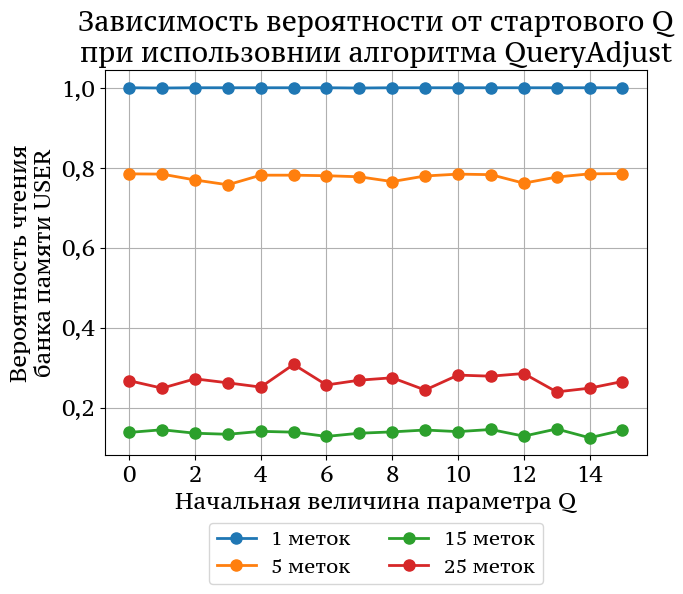

In [35]:
plot_simulations_results(
    results_list=[collision_result["read_user_probs"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость вероятности от стартового Q\nпри использовнии алгоритма QueryAdjust"],
    x_variable=q_variable,
    x_label="Начальная величина параметра Q",
    image_name="Collision probs QAdjust",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)

### 🖼️ Построение графика для времени чтения банка памяти USER

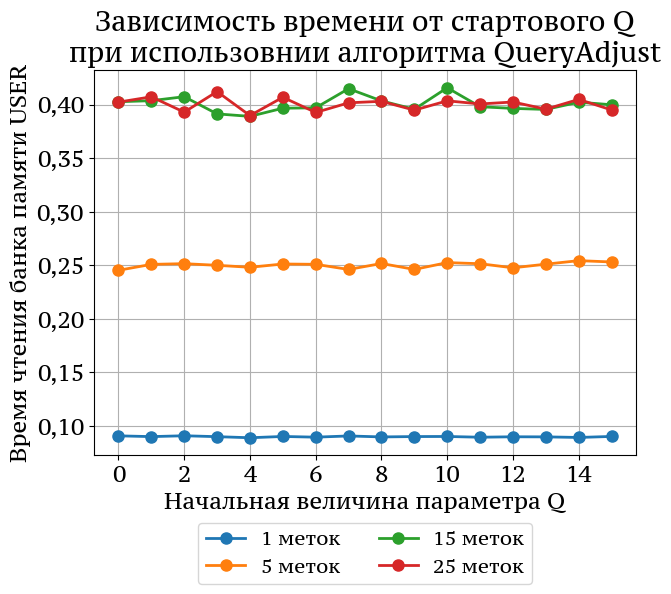

In [37]:
plot_simulations_results(
    results_list=[collision_result["times_count"]],
    labels_list=[key_name(params) for params in tag_period_params],
    titles=["Зависимость времени от стартового Q\nпри использовнии алгоритма QueryAdjust"],
    x_variable=q_variable,
    x_label="Начальная величина параметра Q",
    y_label="Время чтения банка памяти USER",
    image_name="Collision times QAdjust",
    save_fig=SAVE_FIG,
    image_directory=IMG_DIRECTORY,
    integer_labels=True
)